# Denoising Diffusion Probabilistic Models

In [82]:
from typing import *

import jax
import jax.numpy as jnp
import equinox as eqx
import optax

from jax.random import PRNGKey

import matplotlib
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## Inference and learning

<div class="lemma">
    
**Result (DDPM evidence lower bound)** Given a distribution $p$ over $x_{0:T}$ and a distribution $q$ over $x_{1:T} | x_0$, with the following Markov forms
    
$$\begin{align}
p(x_{0:T}) = p(x_T) \prod_{t = 1}^T p(x_{t-1} | x_t) ~~~\text{ and }~~~ q(x_{1:T} | x_0) = \prod_{t = 1}^T q(x_t | x_{t-1}),
\end{align}$$
    
the evidence lower bound (ELBO; also known as the Free Energy) to the marginal log likelihood $\log p(x_0)$, is
    
$$\begin{equation}
\mathbb{E}_q\left[\log \frac{p(x_{0:T})}{q(x_{1:T} | x_0)}\right] = \mathbb{E}_q\left[\log p(x_T) + \sum_{t=1}^T \log \frac{p(x_{t-1} | x_t)}{q(x_t | x_{t-1})} \right].
\end{equation}$$
    
and can be rewritten as
    
$$\begin{equation}
\mathbb{E}_q\left[\log \frac{p(x_{0:T})}{q(x_{1:T} | x_0)}\right] =  \mathbb{E}_q\left[\text{KL}(q(x_T | x_0) || p(x_T)) + \log p(x_0 | x_1) - \sum^T_{t=2} \text{KL}(q(x_{t-1} | x_t, x_0) || p(x_{t-1} | x_t)) \right].
\end{equation}$$
    
</div>
<br>



<details class="proof">
<summary>Derivation: DDPM evidence lower bound</summary>
<br>
   
By Jensen's inequality, for any $p$ and $q$, we have
    
$$\begin{align}
\log p(x_0) \geq \mathbb{E}_q \left[ \log \frac{p(x_{0:T})}{q(x_{1:T} | x_0)}\right].
\end{align}$$
    
The left hand side above is the log-likelihood and the right hand side is the evidence lower bound (ELBO; also known as the Free Energy). Now, if $p$ and $q$ are have the forms
    
$$\begin{align}
p(x_{0:T}) &= p(x_T) \prod_{t = 1}^T p(x_{t-1} | x_t), \\
q(x_{1:T} | x_0) &= \prod_{t = 1}^T q(x_t | x_{t-1}),
\end{align}$$
    
we can substitute these in the expression for the ELBO, and manipulate the term inside the expectation, to obtain
    
$$\begin{align}
\log \frac{p(x_{0:T})}{q(x_{1:T} | x_0)} &= \log p(x_T) + \sum_{t=1}^T \log \frac{p(x_{t-1} | x_t)}{q(x_t | x_{t-1}, x_0)} \\
&= \log p(x_T) + \log \frac{p(x_0 | x_1)}{q(x_1 | x_0)} + \sum_{t=2}^T \log \frac{p(x_{t-1} | x_t)}{q(x_t | x_{t-1}, x_0)} \\
&= \log p(x_T) + \log \frac{p(x_0 | x_1)}{q(x_1 | x_0)} + \sum_{t=2}^T \left[\log \frac{p(x_{t-1} | x_t)}{q(x_t | x_{t-1}, x_0)} + \log \frac{q(x_{t-1} | x_0)}{q(x_t | x_0)} \right] \\
&= \log \frac{p(x_T)}{q(x_T | x_0)} + \log p(x_0 | x_1) + \sum_{t=2}^T \left[\log \frac{p(x_{t-1} | x_t)}{q(x_t | x_{t-1}, x_0)} \right],
\end{align}$$
    
where in the first line we have substituted the expressions for $p$ and $q$, in the second line we have pulled the first term of the sum outside the sum, in the third line we have used Bayes' rule, and in the fourth line we have used the fact that all the $\log q(x_{t-1} | x_0)$ and $\log q(x_t | x_0)$ terms cancel each other (a telescoping sum) except for the $\log q(x_1 | x_0)$ and $\log q(x_T | x_0)$ terms. Now, using the facts that
   
$$\begin{align}
\mathbb{E}_q\left[ \log \frac{q(x_{t-1} | x_t, x_0)}{p(x_{t-1} | x_t)} \right] &= \mathbb{E}_q\Bigg[ \text{KL}(q(x_{t-1} | x_t, x_0) || p(x_{t-1} | x_t)) \Bigg]\\
\mathbb{E}_q\left[ \log \frac{p(x_T)}{q(x_T | x_0)} \right] &= \mathbb{E}_q\Bigg[ \text{KL}(q(x_T | x_0) || p(x_T)) \Bigg]
\end{align}$$
    
we arrive at the result
    
$$\begin{align}
\log p(x_0) \geq \mathbb{E}_q\left[\text{KL}(q(x_T | x_0) || p(x_T)) + \log p(x_0 | x_1) - \sum^T_{t=2} \text{KL}(q(x_{t-1} | x_t, x_0) || p(x_{t-1} | x_t)) \right].
\end{align}$$
    
</details>
<br>



<details class="proof">
<summary>Note: Why rewriting the ELBO is useful (Rao-Blackwellisation)</summary>
<br>
    
The result above is useful for the following reason. In order to learn the generative model $p$, we will need to evaluate the ELBO and its gradients with respect to the parameters of $p$. Because the expectation over $q$ is intractable, we will have to use an approximation, such as Monte Carlo with the reparameterisation trick for computing gradients. The initial form of the ELBO

$$\begin{equation}
\mathbb{E}_q\left[\log \frac{p(x_{0:T})}{q(x_{1:T} | x_0)}\right] = \mathbb{E}_q\left[\log p(x_T) + \sum_{t=1}^T \log \frac{p(x_{t-1} | x_t)}{q(x_t | x_{t-1}, x_0)} \right],
\end{equation}$$

is sufficient for this purpose. In particular, one could draw samples from $q(x_{1:T} | x_0)$ and use them to evaluate a Monte Carlo approximation of the expectation above. However, the usefulness of this estimator will depend on its accuracy, that is the amount of random error present due to the Monte Carlo approximation. Rewriting the expression into

$$\begin{equation}
\mathbb{E}_q\left[\log \frac{p(x_{0:T})}{q(x_{1:T} | x_0)}\right] =  \mathbb{E}_q\left[\text{KL}(q(x_T | x_0) || p(x_T)) + \log p(x_0 | x_1) - \sum^T_{t=2} \text{KL}(q(x_{t-1} | x_t, x_0) || p(x_{t-1} | x_t)) \right],
\end{equation}$$
    
allows us to reduce the random error, because we have already performed some of the expectations. For example, in the proof above, we have used the fact that

$$\begin{equation}
\mathbb{E}_q\left[ \log \frac{q(x_{t-1} | x_t, x_0)}{p(x_{t-1} | x_t)} \right] = \mathbb{E}_q\Bigg[ \text{KL}(q(x_{t-1} | x_t, x_0) || p(x_{t-1} | x_t)) \Bigg],
\end{equation}$$
    
in which $x_{t-1}$ has already been integrated out. A simple Monte Carlo estimate of the right hand side will typically yield smaller (and certainly no greater) variance than a simple Monte Carlo estimate of the left hand side.

</details>
<br>

<div class="lemma">
    
**Result (Closed-form expressions for $q$)** Given a sequence of noise variances $\beta_t$, suppose
    
$$\begin{equation}
q(x_t | x_{t-1}) = \mathcal{N}\left(x_t; \sqrt{1 - \beta_t} x_t, \beta_t I\right),
\end{equation}$$
    
and define $\alpha_t = (1 - \beta_t)$ and $\bar{\alpha}_t = \prod_{t' = 1}^t \alpha_{t'}$. Then
    
$$\begin{align}
q(x_t | x_0) &= \mathcal{N}\left(x_t; \sqrt{\bar{\alpha}_t} x_{t-1}, (1 - \bar{\alpha}_t) I\right) \\
q(x_{t-1} | x_t, x_0) &= \mathcal{N}(x_{t-1}; \tilde{\mu}_t(x_t, x_0), \tilde{\beta}_t I),
\end{align}$$
 
where $\tilde{\mu}_t(x_t, x_0)$ and $\tilde{\beta}_t$ are defined as
    
$$\begin{equation}
\tilde{\mu}_t(x_t, x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_{t-1}} x_0 + \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_{t-1}} x_t ~~\text{ and }~~ \tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t}
\end{equation}$$
    
</div>
<br>


<details class="proof">
<summary>Derivation: Closed-form expression for $q$</summary>
<br>
   
First, note that since $q(x_{1:T} | x_0)$ is Gaussian, all conditionals and marginals of $q$ which we consider in this derivation are also Gaussian. We will show the expression for $q(x_t | x_0)$ by induction. For $t = 1$, we have
    
$$\begin{align}
q(x_1 | x_0) = \mathcal{N}\left(x_1; \sqrt{1 - \beta_1} x_0, \beta_1 I\right) = \mathcal{N}\left(x_t; \sqrt{\bar{\alpha}_1} x_0, (1 - \bar{\alpha}_0) I\right),
\end{align}$$
    
where the first equation holds by the definition of $q(x_t | x_{t-1})$, and the second line follows by the definitions of $\alpha_t$ and $\bar{\alpha}_t$. Now, suppose the expression holds for $n = k$, that is
    
$$\begin{equation}
q(x_k | x_0) = \mathcal{N}\left(x_k; \sqrt{\bar{\alpha}_k} x_{k-1}, (1 - \bar{\alpha}_k) I\right).
\end{equation}$$
    
Then, for $t = k+1$ we have
    
$$\begin{align}
\mathbb{E}\left[x_{k+1} | x_0\right] &= \mathbb{E}\left[\sqrt{1 - \beta_{k+1}} x_k + \sqrt{\beta_{k+1}} \epsilon_{k+1} | x_0\right] \\
&= \sqrt{1 - \beta_{k+1}} \mathbb{E}\left[x_k | x_0\right] \\
&= \sqrt{\alpha_{k+1}} \sqrt{\bar{\alpha}_k} \\
&= \sqrt{\bar{\alpha}_{k+1}},
\end{align}$$

for the expectation, and
    
$$\begin{align}
\mathbb{V}\left[x_{k+1} | x_0\right] &= \mathbb{V}\left[\sqrt{1 - \beta_{k+1}} x_k + \sqrt{\beta_{k+1}} \epsilon_{k+1} | x_0\right] \\
&= (1 - \beta_{k+1}) \mathbb{V}\left[x_k | x_0\right] + \beta_{k+1} \\
&= \alpha_{k+1} (1 - \bar{\alpha}_k) + (1-\alpha_{k+1}) \\
&= 1 - \bar{\alpha}_{k+1}
\end{align}$$
    
for the covariance, which shoes the inductive step. Since the base case and the inductive step holds, the expression for $q(x_t | x_0)$ follows by induction. For the second part of the result, by Bayes' rule, we have 
    
$$\begin{equation}
q(x_{t-1} | x_t, x_0) = \frac{q(x_t | x_{t-1}, x_0) q(x_{t-1} | x_0)}{q(x_t | x_0)}.
\end{equation}$$
    
Since $q(x_{t-1} | x_t, x_0)$ is a Gaussian in $x_{t-1}$, it suffices to compute its mean and covariance. To do this, we will drop all terms which are not dependent on $x_{t-1}$. In particular, we have
    
$$\begin{equation}
q(x_{t-1} | x_t, x_0) \propto q(x_t | x_{t-1}, x_0) q(x_{t-1} | x_0) = q(x_t | x_{t-1}) q(x_{t-1} | x_0),
\end{equation}$$
    
To compute
    
    
$$\begin{equation}
q(x_{t-1} | x_t, x_0) \propto q(x_t | x_{t-1}, x_0) q(x_{t-1} | x_0) = q(x_t | x_{t-1}) q(x_{t-1} | x_0) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_t, \beta_t I) \mathcal{N}(x_{t-1}; \sqrt{\bar{\alpha}_{t-1}} x_{t-1}, (1 - \bar{\alpha}_{t-1}) I),
\end{equation}$$
    
and considering 
    
</details>
<br>

## Implementation

To implement the DDPM, we'll need a few parts. We need to implement the forward (noising) and the reverse (denoising) process, and the model's loss function.

### Network architecture

The denoising (generative) process is parameterised by a neural network. We have a lot of flexibility in specifying this network and the choice of architecture is probably largely dependent on the application of interest. In this example, we will opt to use a simple variant of a UNet architecture,{cite}`ronneberger2015u` because this is generally quick and easy to train. We'll choose roughly sensible hyperparameter settings, and won't spend time trying to optimise the architecture further.

In [78]:
class Identity(eqx.Module):
    """Convenience class for the identity function."""
    
    def __init__(self):
        pass
    
    def __call__(self, x):
        return x

    
class UNetBlock(eqx.Module):
    """Bulk of the UNet architecture. This is constructed recursively, by
    stacking a convolution and a transpose convolution before and after another
    UNet block, respectively, whose number of UNet layers is one than the
    current one, that is
    
        UNetBlock[depth] = ConvTranpose o UNetBlock[depth-1] o Conv
        
    where o is function composition.
    """
    
    # Sub-modules are a downwards (regular) convolution, the UNet sub-block
    # and an upwards (transpose) convolution
    down_conv: eqx.Module
    sub_block: eqx.Module
    up_conv: eqx.Module

    def __init__(
            self,
            layers: int,
            num_channels: int,
            kernel_size: int,
            dim: int,
            key: PRNGKey,
        ):
        """Initialise the UNetBlock.
        
        Arguments:
            layers       : int, number of layers (conv + transpose pairs)
            num_channels : int, number of input channels
            kernel_size  : int, kernel size (square shape)
            dim          : int, dimension of the convolutions
            key          : jax.random.PRNGKey, random key to use
        """
        
        assert layers >= 0
        assert kernel_size % 2 == 1
        
        # Initialise regular (downwards) conv layer
        key, init_key = jax.random.split(key)
        self.down_conv = eqx.nn.Conv(
            num_spatial_dims=dim,
            in_channels=num_channels,
            out_channels=2*num_channels,
            kernel_size=kernel_size,
            stride=2,
            padding=(kernel_size-1)//2,
            key=init_key,
        )
            
        # Initialise UNet sub-block
        key, init_key = jax.random.split(key)
        self.sub_block = UNetBlock(
            layers=layers-1,
            num_channels=2*num_channels,
            kernel_size=kernel_size,
            dim=dim,
            key=init_key,
        ) if layers > 0 else Identity()

        # Initialise transpose (upwards) conv layer
        key, init_key = jax.random.split(key)
        self.up_conv = eqx.nn.ConvTranspose(
            num_spatial_dims=dim,
            in_channels=2*num_channels if layers == 0 else 4*num_channels,
            out_channels=num_channels,
            kernel_size=kernel_size,
            output_padding=1,
            stride=2,
            padding=(kernel_size-1)//2,
            key=init_key,
        )

    def __call__(self, x):
                
        # Store x for skip connection
        skip = x
        
        # Apply downwards convolution, sub-block and upwards convolution
        x = jax.nn.relu(self.down_conv(x))
        x = self.sub_block(x)
        x = jax.nn.relu(self.up_conv(x))
        
        # Concatenate network output with its input for the skip connection
        x = jnp.concatenate([x, skip], axis=0)
        
        return x
    

class UNet(eqx.Module):
    """Full UNet architecture. This consists of a UNetBlock, together with an
    initial (regular) convolution and a final (transpose) convolution, to
    bring the input and output numbers of channels to pre-specified numbers.
    The full UNet architecture is
    
        UNet = ConvTranpose o UNetBlock o Conv
        
    where o is function composition.
    """
    
    unet_block: UNetBlock
    in_conv: eqx.Module
    out_conv: eqx.Module

    def __init__(
            self,
            unet_depth: int,
            num_in_channels: int,
            num_out_channels: int,
            num_channels: int,
            kernel_size: int,
            dim: int,
            key: PRNGKey,
        ):
        """Initialise the UNet.
        
        Arguments:
            unet_depth       : int, number of layers (conv + transpose pairs)
            num_in_channels  : int, number of input channels
            num_out_channels : int, number of output channels
            num_channels     : int, number of UNetBlock input channels
            kernel_size      : int, kernel size (square shape)
            dim              : int, dimension of the convolutions
            key              : jax.random.PRNGKey, random key to use
        """
        
        if not (unet_depth >= 1):
            raise ValueError(f"unet_depth must be >= 1, found {unet_depth}")
        
        # Initialise first (regular) convolution
        key, init_key = jax.random.split(key)
        self.in_conv = eqx.nn.Conv(
            num_spatial_dims=dim,
            in_channels=num_in_channels,
            out_channels=num_channels,
            kernel_size=kernel_size,
            padding=(kernel_size-1)//2,
            stride=1,
            key=init_key,
        )
        
        # Initialise UNetBlock
        key, init_key = jax.random.split(key)
        self.unet_block = UNetBlock(
            layers=unet_depth-1,
            num_channels=num_channels,
            kernel_size=kernel_size,
            dim=dim,
            key=init_key,
        )
        
        # Initialise last (transpose) convolution
        key, init_key = jax.random.split(key)
        self.out_conv = eqx.nn.ConvTranspose(
            num_spatial_dims=dim,
            in_channels=2*num_channels,
            out_channels=num_out_channels,
            kernel_size=kernel_size,
            padding=(kernel_size-1)//2,
            stride=1,
            key=init_key,
        )
        
    def __call__(self, x):
                
        # Apply first convolution with non-linearity
        x = jax.nn.relu(self.in_conv(x))
        
        # Apply UNet block
        x = self.unet_block(x)
        
        # Apply last convolution without non-linearity
        x = self.out_conv(x)
        
        return x

In [71]:
@eqx.filter_value_and_grad
def compute_loss(model, x):
    y = jax.vmap(model)(x)
    return jnp.mean(jnp.mean((y - x)**2., axis=(1, 2, 3)))

@eqx.filter_jit
def make_step(model, x, opt_state):
    loss, grads = compute_loss(model, x)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [72]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type="GPU")

import tensorflow_datasets as tfds

data_dir = "/tmp/tfds"

mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)

x_train = jnp.transpose(mnist_data["train"]["image"], axes=(0, 3, 2, 1)) / 128. - 0.5
x_test = jnp.transpose(mnist_data["test"]["image"], axes=(0, 3, 2, 1)) / 128. - 0.5

In [76]:
unet_depth = 2
num_in_channels = 1
num_out_channels = 1
num_channels = 8
kernel_size = 5
dim = 2

key = jax.random.PRNGKey(0)

input_shape = (num_in_channels,) + dim * (64,)
inputs = jnp.ones(shape=input_shape)

unet = UNet(
    unet_depth=unet_depth,
    num_in_channels=num_in_channels,
    num_out_channels=num_out_channels,
    num_channels=num_channels,
    kernel_size=kernel_size,
    dim=dim,
    key=key,
)

jax.vmap(unet)(x_train[:16]).shape

(16, 1, 28, 28)

In [77]:
optim = optax.adam(1e-3)
opt_state = optim.init(unet)

for i in range(1000):
    
    key, rand_key = jax.random.split(key)
    idx = jax.random.choice(rand_key, 60000, shape=(16,), replace=True)
    loss, unet, opt_state = make_step(unet, x_train[idx], opt_state)
    
    if i % 100 == 0:
        print(f"{loss:.4f}")

0.4661
0.0134
0.0075
0.0038
0.0024
0.0021
0.0012
0.0010
0.0014
0.0011


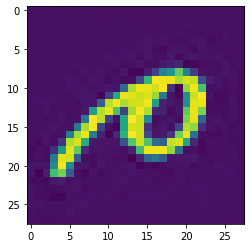

In [67]:
plt.imshow(unet(x_test[100])[0])

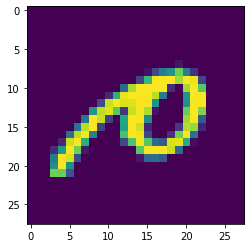

In [68]:
plt.imshow(x_test[100, 0])

## References

```{bibliography} ./references.bib
```